# Práctica calificada 2 - Rodrigo Tay - 20175883

# Preguntas teóricas


## Pregunta 1
  1. La validación cruzada de un modelo permite en todos los casos mejorar
el desempeño predictivo del modelo tanto en la muestra de entrenamiento
como en la de validación.

Respuesta:

No necesariamente. El desempeño predictivo de un modelo podría variar por distintos motivos. Uno de ellos, por ejemplo, es que mi data esté desbalanceada: es decir, que tenga más 0s que 1s. Así haga validación cruzada, este desbalance hará que el poder predictivo de mi modelo empeore demasiado cuando la valide con mi data test.



  2.  Mencione dos diferencias entre un modelo de clasificación logístico versus
un árbol de clasificación.

Respuesta:

Una diferencia importante es que el modelo logístico se explica por sí mismo al ser una función que cuyo output es una probabilidad entre 0 y 1. Es decir, por definición calza con la definición (valga la redundancia) de una probailidad: que va desde 0 a 1. En cambio, un modelo de árbol no funciona así, sino que va dividiendo por tipos de características y un umbral determinado los datos. Aunque el modelo de arbol es fácil de interpretar, su explicabilidad no es tan definidad como el modelo logístico.

Otra diferencia es que el modelo arbol puede trabajar con datos menos limpios y obtener un desempeño predictivo relativamente bueno. En cambio, el modelo logit no corre con missing values o sus resultados predictivos se alteran mucho debido a los outliers. El modelo de árbol es más robusto para datos más "crudos".


# Pregunta 2:

Se les ha encargado estimar un modelo de clasificación para clientes de tarjeta de crédito de una entidad financiera de reciente creación que ha venido utilizando modelos adquiridos a un proveedor. Al ser una entidad relativamente nueva y no haber suficiente muestra para elegir una muestra de validación con desempeño completo (es decir, cuyo default haya sido observado), el equipo recomienda estimar el modelo mientras paralelamente se va generando una muestra de validación, que no estará disponible al momento del desarrollo del modelo. Por lo tanto, se les pide estimar el mejor modelo con la muestra de desarrollo. Pueden utilizar regresiones logísticas o árboles de clasificación, en ambos casos optimizando hiperparámetros. La base de datos ya está limpia de problemas de missings y outliers, por lo que solo tienen que hacer feature engineering

Ruta de trabajo

Aquí detallaré paso a paso qué procedimientos seguiré para estimar el mejor modelo predictivo:

1. Importación de paquetes
2. Apertura del Drive
3. Creación de la función validación
4. Ingeniería de variables (IV) para el modelo logit
5. Optimización de hiper parametros para el modelo logit
6. Corriendo el modelo logit
7. IV para el modelo Árboles de Decision (AD)
8. Optimización de hiper parámetros para el modelo AD
9. Corriendo el modelo AD


## IMPORTACION DE PAQUETES

In [1]:
# @title
#PAQUETES
import IPython
import math
import matplotlib.pyplot as plt
import joblib
import numpy as np
import numpy.matlib
import pandas as pd
import pickle
import pylab
import random
import scipy
import scipy.cluster.hierarchy as shc
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import seaborn as sns

In [2]:
# @title

from numpy import linalg
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.optimize import minimize
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, r2_score, make_scorer, mean_squared_error, mean_absolute_error,roc_curve,accuracy_score,roc_auc_score,brier_score_loss, precision_score, recall_score,precision_recall_curve, f1_score, log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn import tree

##APERTURA DE DRIVE

Hemos subido los datos proporcionados pero en formato excel. La data ha sido duplicada, con una se trabajará el modelo de logit y con la otra el modelo de árboles de decisión. Son tc_loan_train_lg y tc_loan_train_ad, respectivamente.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##CREAMOS LA FUNCIÓN VALIDACION

In [25]:
#Tomamos la función proporcionada por el profesor Bendezú para visualizar las métricas de bondad predictiva
#Pero le hacemos algunos cambios, pues nuestra data no contiene la variable tiempo, así que hemos eliminado esa característica de la función
def validation(fit, fit0, outcome, continuous=False):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.rcParams.update({'font.size': 14})

    if isinstance(fit, pd.Series):
        fit = fit.values
    if isinstance(outcome, pd.Series):
        outcome = outcome.values

    outcomeD = outcome
    if continuous:
        outcomeD = (outcome >= outcome.mean()).astype(int)

    lr_log_loss = log_loss(outcomeD, fit).round(4)
    roc_auc = roc_auc_score(outcomeD, fit).round(4)
    gini = (2 * roc_auc - 1).round(4)
    prec = precision_score(outcomeD, fit0, average='weighted').round(4)
    recall = recall_score(outcomeD, fit0, average='weighted').round(4)
    f1 = f1_score(outcomeD, fit0, average='weighted').round(4)
    binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p=np.mean(fit), alternative='greater').round(4)
    Jeffreys_p = beta.cdf(np.mean(fit), sum(outcomeD) + 0.5, len(outcomeD) - sum(outcomeD) + 0.5).round(4)

    the_table = [['Conteo', len(outcome)],
                 ['RD observado', (sum(outcome) / len(outcome)).round(4)],
                 ['PD estimada', np.mean(fit).round(4)],
                 ['AUC', roc_auc],
                 ['Gini', gini],
                 ['Precisión', prec],
                 ['Recall', recall],
                 ['F1', f1],
                 ['RMSE/ SQR(Brier score)', round(np.sqrt(((outcome - fit).dot(outcome - fit)) / len(outcome)), 4)],
                 ['Log loss', lr_log_loss],
                 ['Binomial p-value', binom_p],
                 ['Jeffreys p-value', Jeffreys_p]]
    the_table = pd.DataFrame(data=the_table)
    the_table.columns = ['Métrica', 'Valor']

    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    plt.subplot(321)
    plt.title('Indicadores')
    plt.axis('off')
    plt.axis('tight')
    test = plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center',
                     colWidths=[0.34, 0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(12)
    test.scale(2, 1)

    fpr, tpr, thresholds = roc_curve(outcome, fit)

    plt.subplot(322)
    plt.title('Curva ROC')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos', fontsize=15)
    plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(loc='best')

    confusion = confusion_matrix(outcome, fit0)

    plt.subplot(323)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos', fontsize=15)
    plt.title('Matriz de Confusión', fontsize=15)

    plt.subplot(324)
    plt.title('Histograma de PDs')
    plt.hist(fit, bins=20, histtype='bar', density=True)
    plt.xlabel('Estimación', fontsize=15)
    plt.ylabel('Frecuencia', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)

##INGENIERIA DE VARIABLES PARA EL MODELO LOGIT
  En esta sección realizaremos la ingeniería de variables para nuestro modelo logit. Tomares los resultados este modelo como una línea de base para poder usarla como guía y punto de comparación al momento de trabajar con el modelo AD.

In [4]:
data=pd.read_excel('/content/drive/MyDrive/2023-2/TOPICOS DE ECO FINANCIERA/PC2/tc_loan_train_lg.xlsx')

In [5]:
data.describe()
#Nos aseguramos que no hayan columnas numéricas con valores únicos revisando que la std sea diferente de 0

,edad,ingreso,tiempo_empleo,monto_prestamo,tasa_int,default,ant_sist_fin
count,22848.000000,2.284800e+04,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000
mean,27.657038,6.675044e+04,4.768339,9653.813244,11.042377,0.215861,5.769827
std,6.042976,5.334133e+04,4.027746,6334.240584,3.225611,0.411428,4.000878
min,20.000000,4.194000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.977175e+04,2.000000,5000.000000,7.900000,0.000000,3.000000
50%,26.000000,5.581700e+04,4.000000,8000.000000,10.990000,0.000000,4.000000
75%,30.000000,8.010925e+04,7.000000,12500.000000,13.472500,0.000000,8.000000
max,65.000000,2.039947e+06,34.000000,35000.000000,23.220000,1.000000,30.000000


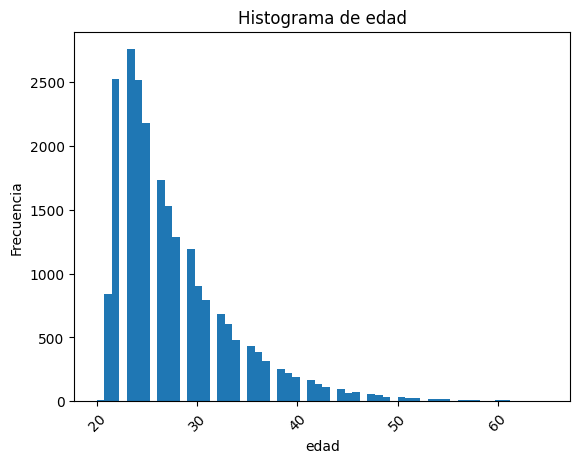

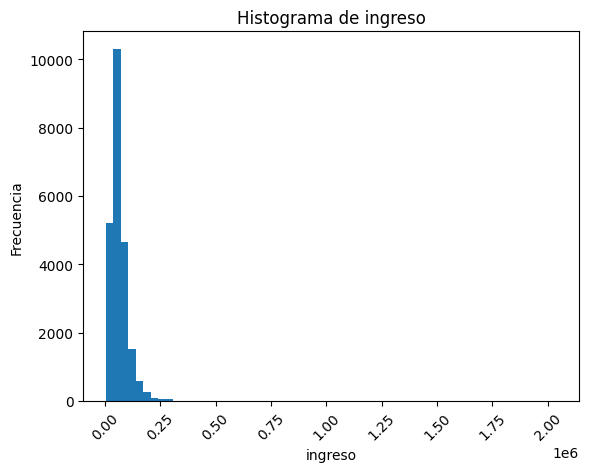

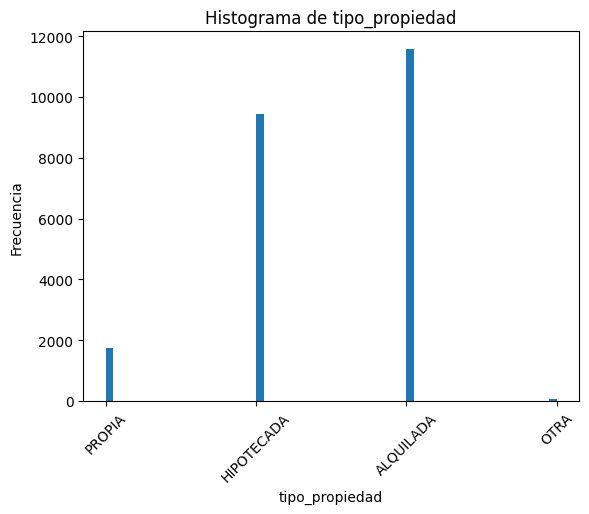

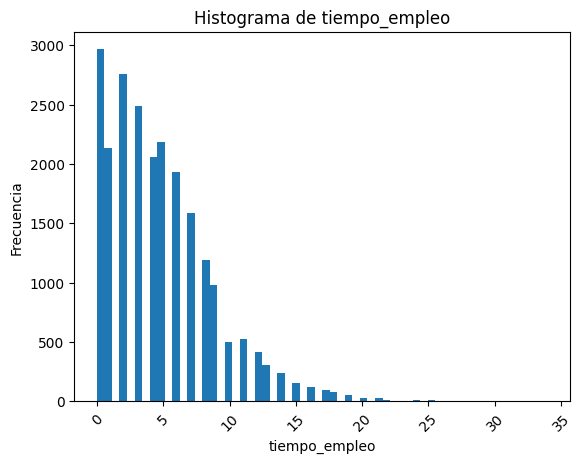

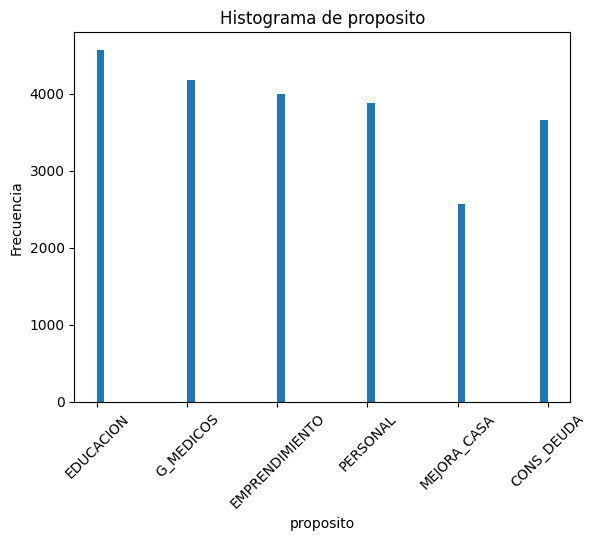

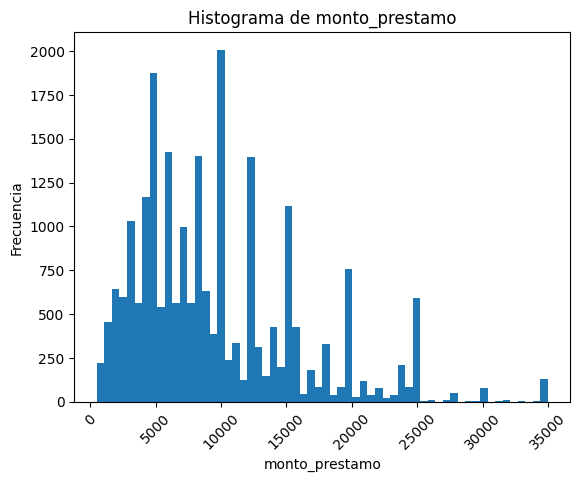

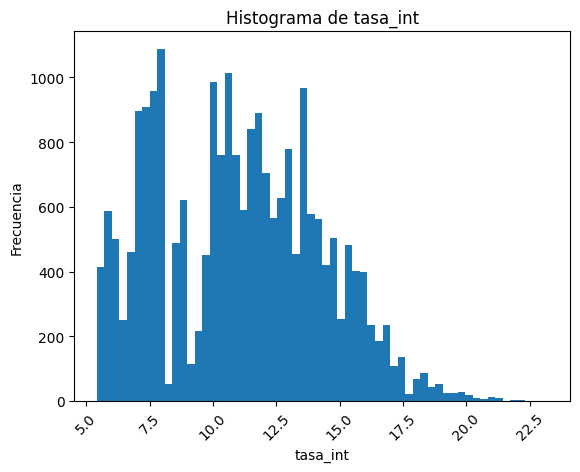

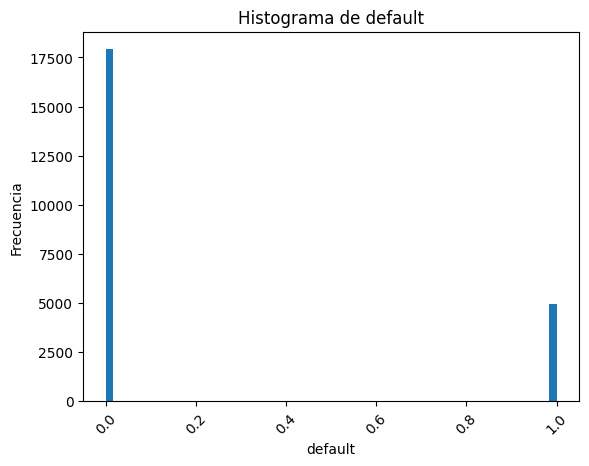

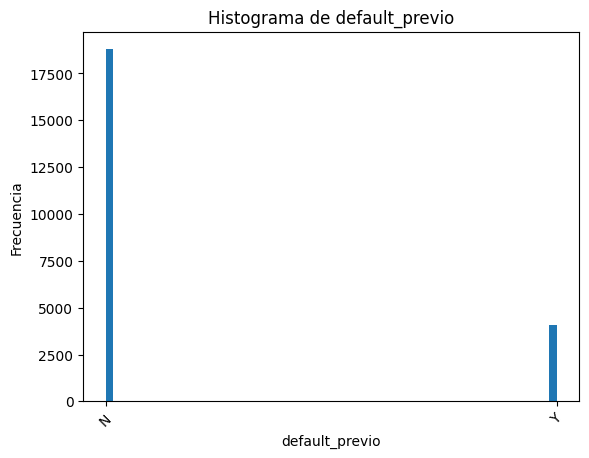

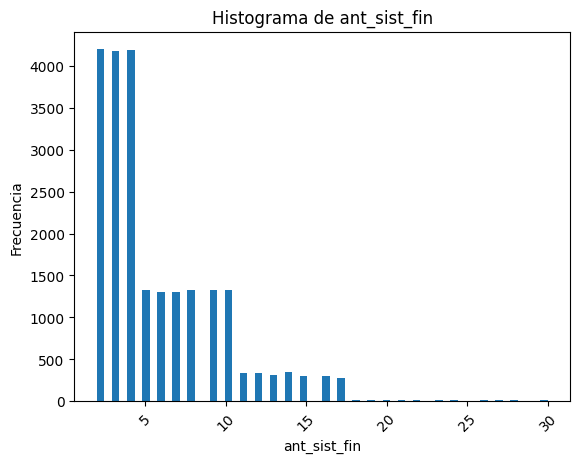

In [6]:
#DISTRIBUCION DE DATOS
#Revisamos cómo se distribuyen los datos, qué tipo de distribución tiene y vemos de qué manera podemos transformarlas.
#A lo largo del código explicaré cómo realicé el tramaje y su explicación
cols_num = ['edad', 'ingreso', 'tipo_propiedad', 'tiempo_empleo', 'proposito', 'monto_prestamo', 'tasa_int', 'default', 'default_previo', 'ant_sist_fin']

for col in cols_num:
    plt.hist(data[col], bins=60)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
#CREACION DE LA VARIABLE RATIO MONTO-INGRESO (RMI)
#Sin dudar iniciamos con la creación del ratio monto-ingreso, que nos da la proporción del préstamo con respecto del ingreso anual de la persona.
#Es útil porque de esa forma podemos usar una sola variable que incorpore otras dos
#Posteriormente eliminaremos monto_prestamo e ingreso

data['RMI'] = data['monto_prestamo'] / data['ingreso']

data.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950


In [8]:
data.describe()

,edad,ingreso,tiempo_empleo,monto_prestamo,tasa_int,default,ant_sist_fin,RMI
count,22848.000000,2.284800e+04,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000
mean,27.657038,6.675044e+04,4.768339,9653.813244,11.042377,0.215861,5.769827,0.169096
std,6.042976,5.334133e+04,4.027746,6334.240584,3.225611,0.411428,4.000878,0.105914
min,20.000000,4.194000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.001282
25%,23.000000,3.977175e+04,2.000000,5000.000000,7.900000,0.000000,3.000000,0.088669
50%,26.000000,5.581700e+04,4.000000,8000.000000,10.990000,0.000000,4.000000,0.147573
75%,30.000000,8.010925e+04,7.000000,12500.000000,13.472500,0.000000,8.000000,0.226615
max,65.000000,2.039947e+06,34.000000,35000.000000,23.220000,1.000000,30.000000,0.825214


In [9]:
#Pensando en qué otra variable se puede crear, llegué a la idea de que esta data no tiene un 'loan grade'
#Eso es extraño porque los prestamos, las tasas de interés, se dan en gran medida, a partir de esa "nota crediticia"
#Y aunque podamos pensar que crear esta "nota" sería muy complicado pues tendríamos que incorporar muchos requisitos,
#Podemos guiarnos de una aseveración que, en el cotexto del ejercicio, es economica y razonablemente cierta: a mejor nota, menor tasa de interés

data['NC'] = pd.cut(data['tasa_int'], bins=[-float('inf'), 7.9, 13.4725, float('inf')], labels=['A', 'B', 'C'], right=False)
data.head(5)
# NC = Nota Crediticia

#Por esa razón creamos 3 categorías: A, B y C, que van de mejor a peor.
#La nota A corresponde a tasas de interés menores a 7.9%
#La nota B corresponde a tasas entre 7.9% y 13.4725%
#Y la nota C a las tasas mayores a 13.47%
#Estos valores son tomados de los valores del primer y último cuartil, según se puede ver en la linea anterior

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A


In [10]:
#Tiene sentido
#La mayoría tiene una nota "intermedia", son menos las personas que están o muy bien o muy mal
value_counts = data['NC'].value_counts()
print("Cantidad de cada valor único en la columna 'NC':")
print(value_counts)

Cantidad de cada valor único en la columna 'NC':
B    11680
C     5712
A     5456
Name: NC, dtype: int64


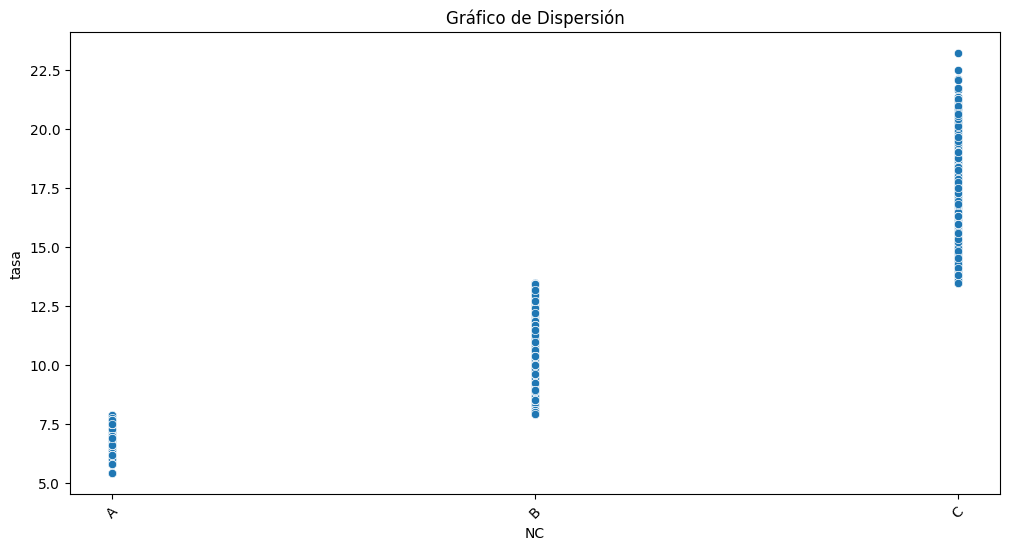

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='NC', y='tasa_int', data=data)
plt.title('Gráfico de Dispersión')
plt.xlabel('NC')
plt.ylabel('tasa')
plt.xticks(rotation=45)  # Inclina las etiquetas del eje x para una mejor legibilidad
plt.show()

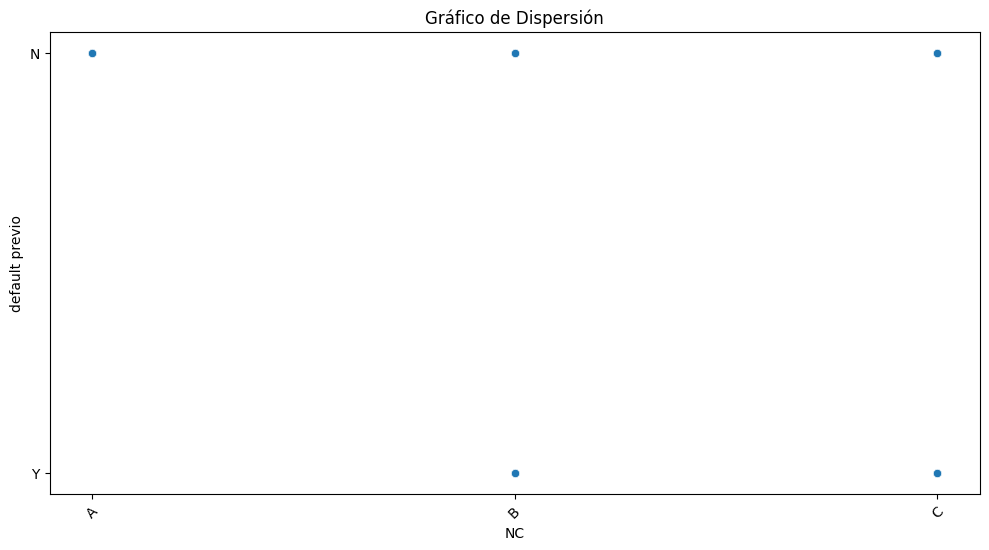

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='NC', y='default_previo', data=data)
plt.title('Gráfico de Dispersión')
plt.xlabel('NC')
plt.ylabel('default previo')
plt.xticks(rotation=45)
plt.show()

#Como se observa en el gráfico, solo aquellos que tienen nota A, nunca antes, en su totalidad como conjunto, han caído en default, en las demás categorías sí

In [13]:
#Partimos en tramos la variable tiempo_empleo
#Aquí partiremos la variable en tres tramos pues tiene una distribución log normal y va descendiendo conforme aumentan los años de trabajo
def time_trab(tiempo_empleo):
    if tiempo_empleo >= 0 and tiempo_empleo < 5:
        return '0-5'
    elif tiempo_empleo >= 5 and tiempo_empleo < 10:
        return '5-10'
    elif tiempo_empleo >= 10 :
        return '>10'
    else:
        return '>10'

# Crea una nueva columna 'time_trab' usando la función
data['time_trab'] = data['tiempo_empleo'].apply(time_trab)
data.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC,time_trab
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B,5-10
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B,0-5
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C,0-5
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C,5-10
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A,0-5


In [14]:
#Tiene sentido
#A más años de trabajo, menor número de observaciones
#Esto se explica porque la muestra es de personas bastante jóvenes
value_counts = data['time_trab'].value_counts()
print("Cantidad de cada valor único en la columna 'time_trab':")
print(value_counts)

Cantidad de cada valor único en la columna 'time_trab':
0-5     12399
5-10     7860
>10      2589
Name: time_trab, dtype: int64


In [15]:
#Partimos en tramos la variable loan_int_rate
#Aquí podemos tanto partir la tasa de interés en tramos de 2.5 en 2.5, tanto como no hacerlo pues ya se encuentra dentro de las cateogría de NC.
#En este caso no lo haremos, pero igual dejaré el código

#   if tasa_int >= 5 and tasa_int < 7.5:
 #       return 'r_int 5-7.5'
  #  elif tasa_int >= 7.5 and tasa_int < 10:
   #     return 'r_int 7.5-10'
    #elif tasa_int >= 10 and tasa_int < 12.5:
     #   return 'r_int 10-12.5'
    #elif tasa_int >= 12.5 and tasa_int < 15:
     #   return 'r_int 12.5-15'
    #elif tasa_int >= 15 and tasa_int < 17.5:
     #   return 'r_int 15-17.5'
    #else:
     #   return '17.5+'

# Crea una nueva columna 'loan_int_range' usando la función
#data['rango_tint'] = data['tasa_int'].apply(rango_tint)
#data.head(5)

In [16]:
data.head()

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC,time_trab
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B,5-10
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B,0-5
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C,0-5
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C,5-10
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A,0-5


In [17]:
#Partimos en tramos la variable ant_sist_fin
#Como podemos ver en su distribución, esta variable está partida en tres tramos claros
def rango_cred(ant_sist_fin):
    if ant_sist_fin >= 0 and ant_sist_fin < 5:
        return 'hist 0-5'
    elif ant_sist_fin >= 5 and ant_sist_fin < 10:
        return 'hist 5-10'
    elif ant_sist_fin >= 10 and ant_sist_fin < 17:
        return 'hist 10-17'
    elif ant_sist_fin >= 17:
        return 'hist 17+'
    else:
        return 'hist 17+'

# Crea una nueva columna 'percent_income_range' usando la función
data['rango_cred'] = data['ant_sist_fin'].apply(rango_cred)
data.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC,time_trab,rango_cred
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B,5-10,hist 0-5
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B,0-5,hist 0-5
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C,0-5,hist 0-5
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C,5-10,hist 0-5
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A,0-5,hist 0-5


In [18]:
#Tiene sentido
#A menos años de historialo, menor número de observaciones
#Esto se explica porque la muestra es de personas bastante jóvenes
value_counts = data['rango_cred'].value_counts()
print("Cantidad de cada valor único en la columna 'rango_cred':")
print(value_counts)

Cantidad de cada valor único en la columna 'rango_cred':
hist 0-5      12559
hist 5-10      6583
hist 10-17     3256
hist 17+        450
Name: rango_cred, dtype: int64


In [19]:
#Realizamos un tramaje de la variable RMI de 0.1 en 0.1
def rango_RMI(RMI):
    if RMI >= 0 and RMI < 0.1:
        return '0-0.1'
    elif RMI >= 0.1 and RMI < 0.2:
        return '0.1-0.2'
    elif RMI >= 0.2 and RMI < 0.3:
        return '0.2-0.3'
    elif RMI >= 0.3 and RMI < 0.4:
        return '0.3-0.4'
    elif RMI >= 0.4:
        return '0.4+'
    else:
        return '0.4+'

# Crea una nueva columna 'percent_income_range' usando la función
data['rango_RMI'] = data['RMI'].apply(rango_RMI)
data.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC,time_trab,rango_cred,rango_RMI
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B,5-10,hist 0-5,0.1-0.2
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B,0-5,hist 0-5,0.4+
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C,0-5,hist 0-5,0.4+
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C,5-10,hist 0-5,0.4+
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A,0-5,hist 0-5,0.2-0.3


In [20]:
#Aunque para el caso de las categorías 0-0.1 y 0.1-0.2 hay una diferencia. Sigue teniendo sentido que para tasas bajas, hayan bastante observaciones.
#Para tasas de entre 0.2 y 0.4 sí son más escazos y van disminuyendo.
#Tiene sentido
value_counts = data['rango_RMI'].value_counts()
print("Cantidad de cada valor único en la columna 'rango_RMI':")
print(value_counts)

Cantidad de cada valor único en la columna 'rango_RMI':
0.1-0.2    8632
0-0.1      7015
0.2-0.3    4459
0.3-0.4    1950
0.4+        792
Name: rango_RMI, dtype: int64


In [21]:
data.head()

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC,time_trab,rango_cred,rango_RMI
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B,5-10,hist 0-5,0.1-0.2
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B,0-5,hist 0-5,0.4+
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C,0-5,hist 0-5,0.4+
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C,5-10,hist 0-5,0.4+
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A,0-5,hist 0-5,0.2-0.3


In [22]:
droping = ['edad', 'tiempo_empleo', 'tasa_int', 'ant_sist_fin', 'RMI','ingreso','monto_prestamo']
for x in droping:
  data = data.drop(columns=[x])
data.head(5)



,tipo_propiedad,proposito,default,default_previo,NC,time_trab,rango_cred,rango_RMI
0,PROPIA,EDUCACION,0,N,B,5-10,hist 0-5,0.1-0.2
1,HIPOTECADA,G_MEDICOS,1,N,B,0-5,hist 0-5,0.4+
2,ALQUILADA,G_MEDICOS,1,N,C,0-5,hist 0-5,0.4+
3,ALQUILADA,G_MEDICOS,1,Y,C,5-10,hist 0-5,0.4+
4,PROPIA,EMPRENDIMIENTO,1,N,A,0-5,hist 0-5,0.2-0.3


In [23]:
#Hacemos un reemplazamiento rápido de la variable default previo
data['default_previo'] = data['default_previo'].replace({'N': 0, 'Y': 1})
data.head()

,tipo_propiedad,proposito,default,default_previo,NC,time_trab,rango_cred,rango_RMI
0,PROPIA,EDUCACION,0,0,B,5-10,hist 0-5,0.1-0.2
1,HIPOTECADA,G_MEDICOS,1,0,B,0-5,hist 0-5,0.4+
2,ALQUILADA,G_MEDICOS,1,0,C,0-5,hist 0-5,0.4+
3,ALQUILADA,G_MEDICOS,1,1,C,5-10,hist 0-5,0.4+
4,PROPIA,EMPRENDIMIENTO,1,0,A,0-5,hist 0-5,0.2-0.3


In [24]:
#Damizamos
data = pd.get_dummies(data, columns=['NC', 'time_trab', 'rango_cred', 'rango_RMI', 'tipo_propiedad', 'proposito'], drop_first=True)
data.head(4)

,default,default_previo,NC_B,NC_C,time_trab_5-10,time_trab_>10,rango_cred_hist 10-17,rango_cred_hist 17+,rango_cred_hist 5-10,rango_RMI_0.1-0.2,...,rango_RMI_0.3-0.4,rango_RMI_0.4+,tipo_propiedad_HIPOTECADA,tipo_propiedad_OTRA,tipo_propiedad_PROPIA,proposito_EDUCACION,proposito_EMPRENDIMIENTO,proposito_G_MEDICOS,proposito_MEJORA_CASA,proposito_PERSONAL
0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,1,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


Qué tenemos hasta aquí:

Hemos creado una tabla con 21 columnas, de las cuales 20 serían los "features". Este número de variables se puede reducir o aumentar. Podríamos tener más Notas Crediticias, por ejemplo, o menos tramos, pero lo hacemos así porque posteriormente realizaremos regularización. De este modo, será esta técnica la que decidirá la inclusión o no de un "feature" en específico y no será arbitrario.

##OPTIMIZACION DE HIPER PARÁMETROS PARA EL MODELO LOGIT

In [26]:
X = data.drop('default', axis=1)
y = data['default']

# Dividir los datos en conjuntos de entrenamiento y prueba para poder hacer cross validation con nuestra propia data train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

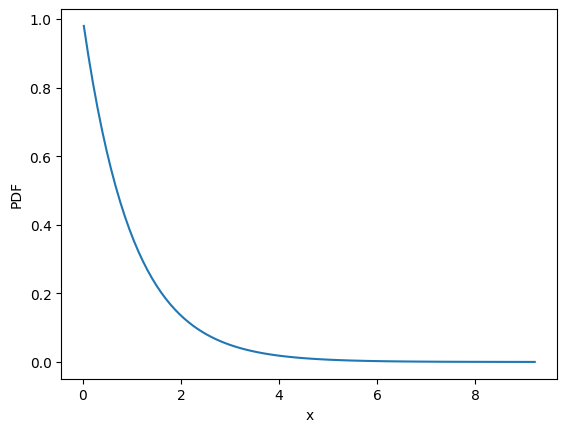

In [27]:
#optimizar hiperparametros

lambda_exp = 0.5
scale = 1/lambda_exp
x = np.linspace(expon.ppf(0.01)*scale, expon.ppf(0.99)*scale, 100)

plt.plot(x, expon.pdf(x))
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

In [28]:
np.random.seed(2011)
params_lr = {'penalty': ['l1', 'l2'], 'C': expon(scale=0.5)}

In [29]:
model_lr_reg = LogisticRegression(fit_intercept=True, solver='saga', tol=1e-15, max_iter=100)

In [30]:
#Aquí estamos iterando 5 veces para 100 candidatos posibles de C, para L1 y L2
rs_lr = RandomizedSearchCV(model_lr_reg, params_lr, verbose=1, n_iter=100, n_jobs=2, cv=5,  random_state=12345, scoring='roc_auc')
rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(solver='saga', tol=1e-15),
                   n_iter=100, n_jobs=2,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7be4af781ae0>,
                                        'penalty': ['l1', 'l2']},
                   random_state=12345, scoring='roc_auc', verbose=1)

In [31]:
#Mostramos el mejor valor de C
print(rs_lr.best_params_)
filename = 'Mortgage_lr_RandomizedSearch.sav'
pickle.dump(rs_lr, open(filename, 'wb'))

{'C': 0.8939426971552675, 'penalty': 'l2'}


##CORRIENDO EL MODELO LOGIT

In [32]:
model_lr_best = LogisticRegression(penalty = rs_lr.best_params_.get('penalty'),  C = rs_lr.best_params_.get('C'),  fit_intercept=True, solver='saga', tol=1e-15, max_iter=5000)

In [33]:
# Ajustamos el modelo de regresión logística e imprimimos los coeficientes para cada variable
model_lr_best.fit(X_train, y_train)

feature_names = X_train.columns
coef_values = model_lr_best.coef_.round(decimals=4)
intercept_value = model_lr_best.intercept_.round(decimals=4)
for coef, feature_name in zip(coef_values[0], feature_names):
    print(f'Coeficiente para {feature_name}: {coef}')

print('Intercepto:', intercept_value)
#El análisis que hagamos ahora tiene que ser por grupo de variables y después una comparación entre ellas
#Para default_previo: 0.2475
#Para NC: NC_C: 2.13
#Para años trabajando: time_Trab_>10_: -0.1273
#Para rango_cred_hist el más relevante es el que va de 10-17: -0,2107
#Para el de rango RMI hay dos: RMI 0.3-0.4 con 3.118 Y RMI > 0.4 con 3.76
#Para tipo de propiedad, la casa propia tiene -2.3261
#Para propósito, los mayores son educacion y emprendimiento


Coeficiente para default_previo: 0.2443
Coeficiente para NC_B: 0.5062
Coeficiente para NC_C: 2.1293
Coeficiente para time_trab_5-10: -0.2725
Coeficiente para time_trab_>10: -0.2207
Coeficiente para rango_cred_hist 10-17: -0.2379
Coeficiente para rango_cred_hist 17+: -0.1993
Coeficiente para rango_cred_hist 5-10: -0.1514
Coeficiente para rango_RMI_0.1-0.2: 0.2429
Coeficiente para rango_RMI_0.2-0.3: 0.7062
Coeficiente para rango_RMI_0.3-0.4: 3.1287
Coeficiente para rango_RMI_0.4+: 3.7641
Coeficiente para tipo_propiedad_HIPOTECADA: -1.0085
Coeficiente para tipo_propiedad_OTRA: -0.494
Coeficiente para tipo_propiedad_PROPIA: -2.3173
Coeficiente para proposito_EDUCACION: -0.8606
Coeficiente para proposito_EMPRENDIMIENTO: -1.0909
Coeficiente para proposito_G_MEDICOS: -0.0937
Coeficiente para proposito_MEJORA_CASA: 0.0319
Coeficiente para proposito_PERSONAL: -0.589
Intercepto: [-2.0441]


Como conclusión podemos verificar que la regularización le impone pesos muchos mayores a dos categorías: NC y rango_RMI, las demás no llegan a ser 1 si quiera. Solo podríamos rescatar el tipo de propiedad. Esto nos debe dar mayores luces para luego proceder con el modelo de árboles de decisión.

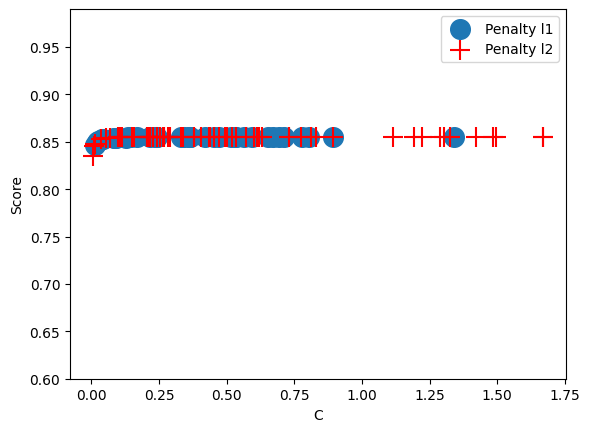

In [34]:
results = pd.DataFrame(rs_lr.cv_results_.get('params'))
results['mean_test_score'] = rs_lr.cv_results_['mean_test_score']
results_l1 = results[results['penalty']=='l1']
results_l2 = results[results['penalty']=='l2']

plt.scatter(results_l1['C'], results_l1['mean_test_score'], s=200, label = 'Penalty l1')
plt.scatter(results_l2['C'], results_l2['mean_test_score'], s=200, marker = '+', color = 'red', label = 'Penalty l2')
plt.ylabel('Score')
plt.xlabel('C')
plt.ylim(0.60, 0.99)
plt.legend()
plt.show()


<ipython-input-25-119ebdb93eb2>:23: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p=np.mean(fit), alternative='greater').round(4)


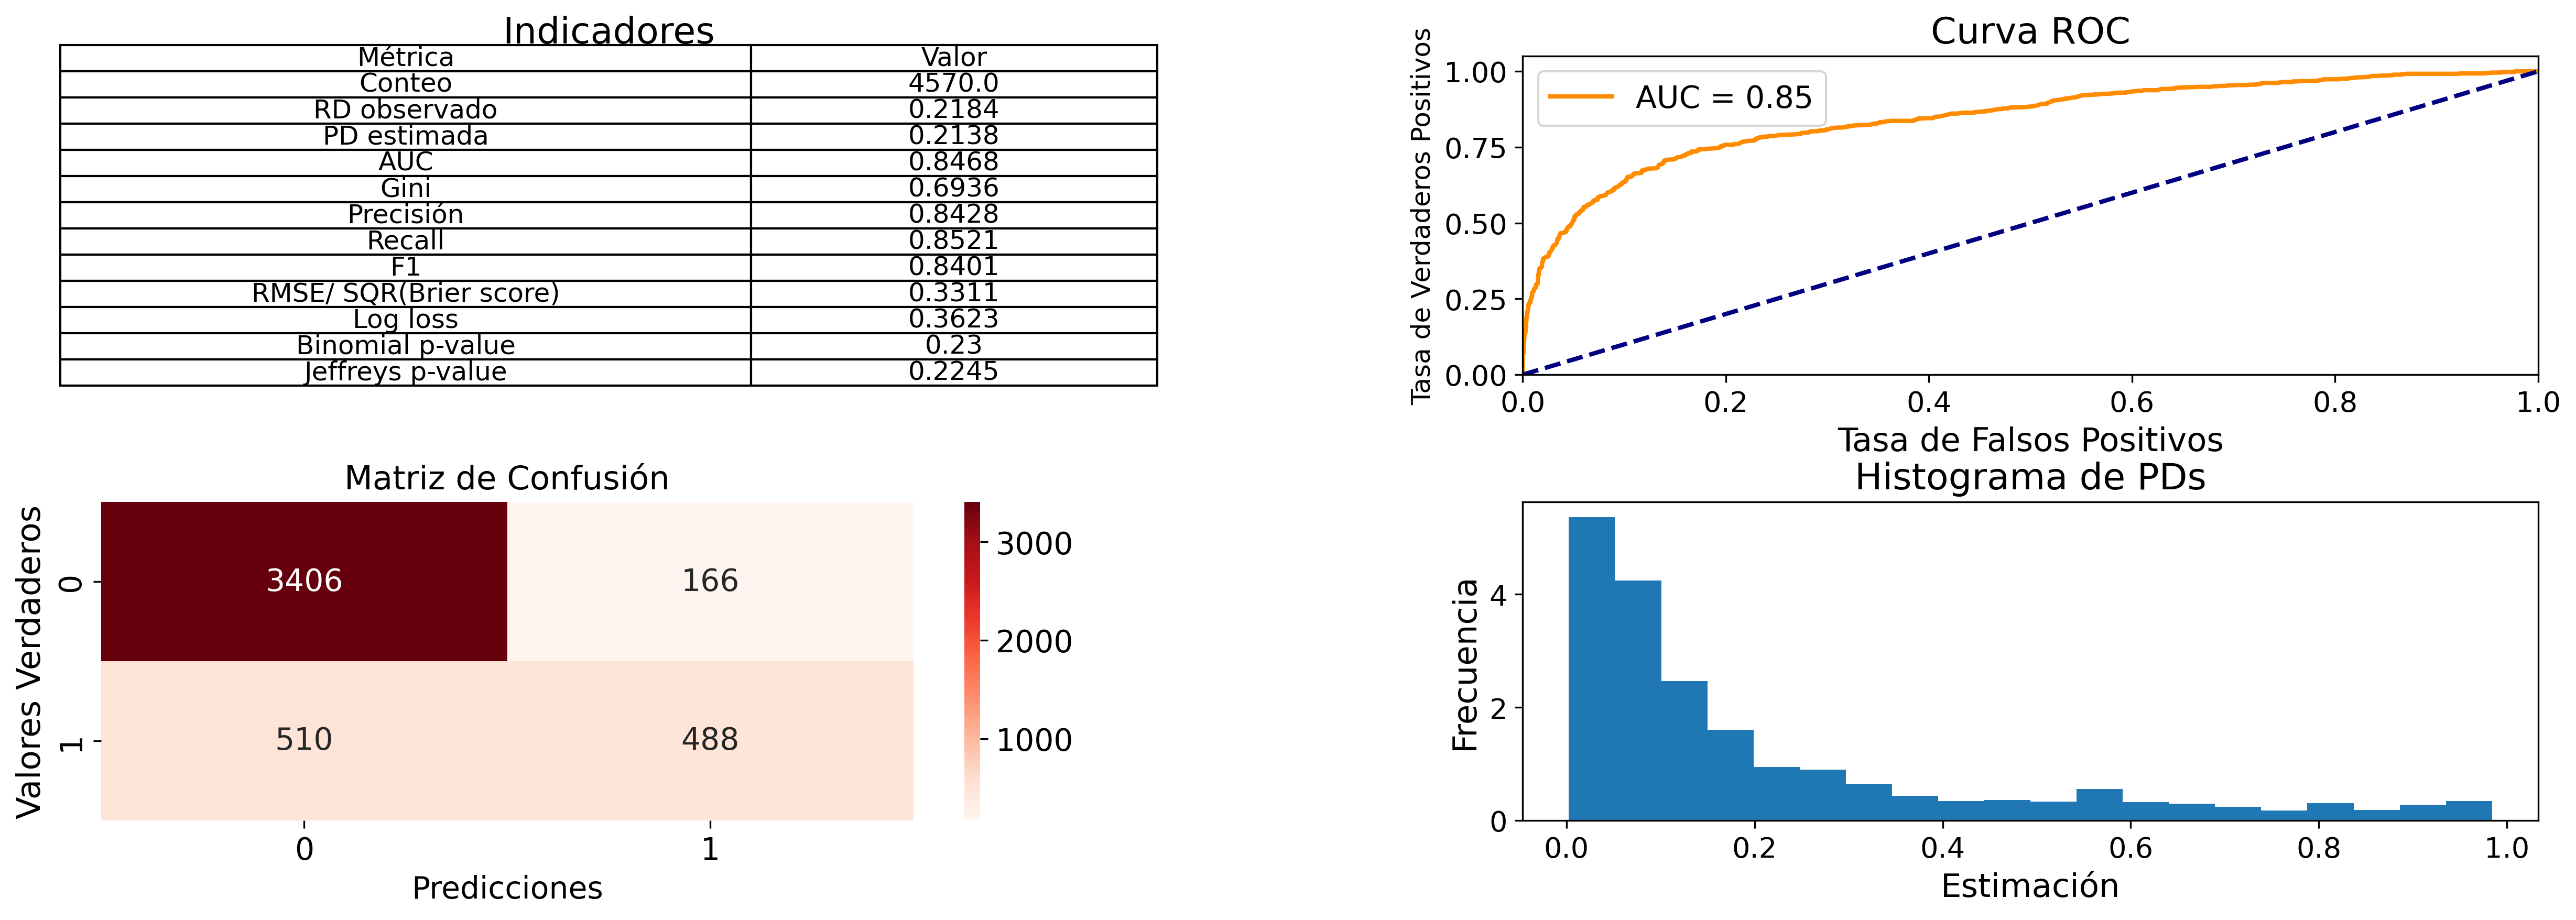

In [35]:
predictions_test = model_lr_best.predict_proba(X_test)[:,1].T
predictions_test_1 = model_lr_best.predict(X_test)

validation(predictions_test, predictions_test_1, y_test, continuous=False)
AUC_logreg_reg3 = roc_auc_score(y_test, predictions_test).round(4)
sqrt_brier_logreg_reg3 = np.sqrt(brier_score_loss(y_test, predictions_test)).round(4)

Verificamos que el modelo performa bien con la data de entrenamiento, con un AUC de .85 y un GINI de .6956. Sin embargo, esto no quiere decir que este modelo sea el mejor posible, sino que es solo una linea de base para poder decidir posteriormente cómo proceder en el modelo de árboles de decisión.

Algo importante a mencionar es que este modelo cuenta con demasiados features, por lo que se corregirá posteriormente en el siguiente modelo.

## INGENIERIA DE VARIABLES PARA EL MODELO ARBOLES DE DECISION

Como concluimos en la parte anterior, son pocas las variables de nuestra muestra las que realmente tienen un poder explicativo que favorezca a nuestro modelo. En el caso del modelo AD (Arboles de Decisión) debemos tomar en cuenta que este es sensible al número de features que se le aplique, lo que puede generar problemas de sobre ajuste. En el modelo logit, como aplicamos regularización, pudimos trabajar con 25 variables. Sin embargo, para este modelo, tendremos que disminuir ese número.

A partir de la experiencia con el modelo logit y la regularización, lo mejor será trabajar con las variables tipo_propiedad, RMI y NC.

In [256]:
data_ad=pd.read_excel('/content/drive/MyDrive/2023-2/TOPICOS DE ECO FINANCIERA/PC2/tc_loan_train_ad.xlsx')

In [228]:
data_ad.head()

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2


In [202]:
correlation_matrix = data_ad.corr()

# Obtener la correlación de todas las variables con 'default'
correlation_with_default = correlation_matrix['default'].drop('default')  # Elimina la correlación consigo misma

# Mostrar las correlaciones
print(correlation_with_default)

#A partir de este cuadro vuelvo a confirmar que debo usar la tasa de interes y el RMI

edad             -0.022437
ingreso          -0.163486
tiempo_empleo    -0.083159
monto_prestamo    0.112081
tasa_int          0.336972
ant_sist_fin     -0.016108
RMI               0.387090
Name: default, dtype: float64


<ipython-input-202-635988da7b75>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_ad.corr()


In [210]:
contingency_table = pd.crosstab(data_ad['proposito'], data_ad['default'])

# Muestra la tabla de contingencia
print(contingency_table)
#No observo una gran clasificación de los datos como para poder considerarlo dentro de mi modelo

default            0     1
proposito                 
CONS_DEUDA      2637  1022
EDUCACION       3795   773
EMPRENDIMIENTO  3423   567
G_MEDICOS       3047  1136
MEJORA_CASA     1902   663
PERSONAL        3112   771


In [209]:
contingency_table2 = pd.crosstab(data_ad['tipo_propiedad'], data_ad['default'])

# Muestra la tabla de contingencia
print(contingency_table2)
#observo una clasificación de las personas que tienen hipoteca, los no defaults son 8 veces más que los defaults, algo similar sucede con quienes tienen casa propia
#Así que asumiré que quienes hipotecan o tienen casa propia, no harán default y los demás sí

default            0     1
tipo_propiedad            
ALQUILADA       7991  3590
HIPOTECADA      8260  1197
OTRA              56    20
PROPIA          1609   125


In [211]:
contingency_table3 = pd.crosstab(data_ad['default_previo'], data_ad['default'])

# Muestra la tabla de contingencia
print(contingency_table3)

#Aquí solo observo una clasificacion de 5 veces una sobre la otra, podría incorporarla como no, por prueba y error, incorporarla no me baja el AUC
#Y como menos es más para el modelo del arbol, entonces preferiré no incorporarla

default             0     1
default_previo             
N               15393  3396
Y                2523  1536


In [257]:
#CREACION DE LA VARIABLE RATIO MONTO-INGRESO (RMI)

data_ad['RMI'] = data_ad['monto_prestamo'] / data_ad['ingreso']

data_ad.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950


In [169]:
data_ad.describe()

,edad,ingreso,tiempo_empleo,monto_prestamo,tasa_int,default,ant_sist_fin,RMI
count,22848.000000,2.284800e+04,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000
mean,27.657038,6.675044e+04,4.768339,9653.813244,11.042377,0.215861,5.769827,0.169096
std,6.042976,5.334133e+04,4.027746,6334.240584,3.225611,0.411428,4.000878,0.105914
min,20.000000,4.194000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.001282
25%,23.000000,3.977175e+04,2.000000,5000.000000,7.900000,0.000000,3.000000,0.088669
50%,26.000000,5.581700e+04,4.000000,8000.000000,10.990000,0.000000,4.000000,0.147573
75%,30.000000,8.010925e+04,7.000000,12500.000000,13.472500,0.000000,8.000000,0.226615
max,65.000000,2.039947e+06,34.000000,35000.000000,23.220000,1.000000,30.000000,0.825214


In [258]:
# PARTICION DE LA VARIABLE NC EN 3 CATEGORIAS
data_ad['NC'] = pd.cut(data_ad['tasa_int'], bins=[-float('inf'), 7.9, 13.4725, float('inf')], labels=['A', 'B', 'C'], right=False)
data_ad.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC
0,21,9766,PROPIA,5,EDUCACION,1000,11.14,0,N,2,0.102396,B
1,25,9799,HIPOTECADA,1,G_MEDICOS,5500,12.87,1,N,3,0.561282,B
2,23,65627,ALQUILADA,4,G_MEDICOS,35000,15.23,1,N,2,0.533317,C
3,24,54528,ALQUILADA,8,G_MEDICOS,35000,14.27,1,Y,4,0.641872,C
4,21,10002,PROPIA,2,EMPRENDIMIENTO,2500,7.14,1,N,2,0.249950,A


In [259]:
# CAMBIAMOS EL TIPO DE PROPIEDAD A SOLAMENTE PROPIO O NO PROPIO, SIGUIENDO LOS RESULTADOS ANTERIORES DEL LOGIT
data_ad['tipo_propiedad'] = data_ad['tipo_propiedad'].replace(['HIPOTECADA', 'PROPIA'], 0)
data_ad['tipo_propiedad'] = data_ad['tipo_propiedad'].replace(['ALQUILADA', 'OTRA'], 1)
data_ad['default_previo'] = data_ad['default_previo'].replace({'N': 0, 'Y': 1})

data_ad.head(5)

,edad,ingreso,tipo_propiedad,tiempo_empleo,proposito,monto_prestamo,tasa_int,default,default_previo,ant_sist_fin,RMI,NC
0,21,9766,0,5,EDUCACION,1000,11.14,0,0,2,0.102396,B
1,25,9799,0,1,G_MEDICOS,5500,12.87,1,0,3,0.561282,B
2,23,65627,1,4,G_MEDICOS,35000,15.23,1,0,2,0.533317,C
3,24,54528,1,8,G_MEDICOS,35000,14.27,1,1,4,0.641872,C
4,21,10002,0,2,EMPRENDIMIENTO,2500,7.14,1,0,2,0.249950,A


In [260]:
# Eliminamos las variables que no usaremos
drops = ['edad','ingreso', 'tiempo_empleo', 'monto_prestamo', 'tasa_int', 'ant_sist_fin', 'proposito', 'default_previo']
for x in drops:
  data_ad = data_ad.drop(columns=[x])
data_ad.head(5)

,tipo_propiedad,default,RMI,NC
0,0,0,0.102396,B
1,0,1,0.561282,B
2,1,1,0.533317,C
3,1,1,0.641872,C
4,0,1,0.249950,A


In [261]:
#Realizamos un tramaje de la variable RMI de 0.1 en 0.1, realizamos mayores tramos para una mejor clasificación
def rango_RMI(RMI):
    if RMI >= 0 and RMI < 0.1:
        return '0.0-0.1'
    elif RMI >= 0.1 and RMI < 0.2:
        return '0.1-0.2'
    elif RMI >= 0.2 and RMI < 0.3:
        return '0.2-0.3'
    elif RMI >= 0.3 and RMI < 0.4:
        return '0.3-0.4'
    elif RMI >= 0.4:
        return '0.4+'
    else:
        return '0.4+'

# Crea una nueva columna 'rango_RMI'
data_ad['rango_RMI'] = data_ad['RMI'].apply(rango_RMI)
data_ad.head(5)

,tipo_propiedad,default,RMI,NC,rango_RMI
0,0,0,0.102396,B,0.1-0.2
1,0,1,0.561282,B,0.4+
2,1,1,0.533317,C,0.4+
3,1,1,0.641872,C,0.4+
4,0,1,0.249950,A,0.2-0.3


In [262]:
# Borramos RMI
data_ad = data_ad.drop(columns=['RMI'])
data_ad.head(3)

,tipo_propiedad,default,NC,rango_RMI
0,0,0,B,0.1-0.2
1,0,1,B,0.4+
2,1,1,C,0.4+


In [263]:
#Damizamos
data_ad = pd.get_dummies(data_ad, columns=['NC', 'rango_RMI'], drop_first=True)
data_ad.head(4)

,tipo_propiedad,default,NC_B,NC_C,rango_RMI_0.1-0.2,rango_RMI_0.2-0.3,rango_RMI_0.3-0.4,rango_RMI_0.4+
0,0,0,1,0,1,0,0,0
1,0,1,1,0,0,0,0,1
2,1,1,0,1,0,0,0,1
3,1,1,0,1,0,0,0,1


Ahora ya tenemos una tabla con solo 9 variables damizadas, que es un 60% menos que la cantidad de variables usadas en el logit.

## OPTIMIZANDO HIPER PARAMETROS PARA EL MODELO DE ARBOLES DE DECISION

In [269]:
X_ad = data_ad.drop('default', axis=1)
y_ad = data_ad['default']

# Dividir los datos en conjuntos de entrenamiento y prueba para realizar validación cruzada
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_ad, y_ad, test_size=0.2, random_state=1000)

#Hacemos CV para hallar la profundidad y número de features óptimos
params_dt = {'max_depth': np.arange(2,10,1),  'max_features': np.arange(2,10,1)}
model_dt = DecisionTreeClassifier(random_state=12389)

gs_dt = GridSearchCV(model_dt, params_dt, verbose=1, n_jobs=2, cv=10, scoring='roc_auc')
gs_dt.fit(X_train_ad, y_train_ad)

print(gs_dt.best_params_)

filename = 'PC2OPT_dt_GridSearch.sav'
pickle.dump(gs_dt, open(filename, 'wb'))

Fitting 10 folds for each of 64 candidates, totalling 640 fits
{'max_depth': 7, 'max_features': 2}


In [249]:
display(X_train_ad)

,tipo_propiedad,NC_B,NC_C,rango_RMI_0.1-0.2,rango_RMI_0.2-0.3,rango_RMI_0.3-0.4,rango_RMI_0.4+
17227,0,0,1,1,0,0,0
785,1,1,0,0,0,1,0
3096,0,1,0,1,0,0,0
7737,1,0,1,1,0,0,0
14566,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...
15611,1,0,1,1,0,0,0
3776,1,1,0,1,0,0,0
6215,0,0,1,0,1,0,0
4695,1,0,0,1,0,0,0


In [250]:
#Hacemos CV para encontrar el mejor modelo
print(cross_val_score(model_dt, X_train_ad, y_train_ad, cv=10, scoring='roc_auc'))

[0.85536878 0.81334681 0.85646638 0.85865184 0.84862725 0.86121583
 0.83473865 0.85873174 0.84420436 0.85096937]


In [265]:
#Fiteamos el modelo con la profundida y número de features óptimas
filename = 'PC2OPT_dt_GridSearch.sav'
gs_dt = pickle.load(open(filename, 'rb'))

model_dt_best = DecisionTreeClassifier(random_state=12389, max_depth = gs_dt.best_params_.get('max_depth'),  max_features = gs_dt.best_params_.get('max_features'))
model_dt_best.fit(X_train_ad, y_train_ad)

DecisionTreeClassifier(max_depth=7, max_features=2, random_state=12389)

In [252]:
#Volvemos a hacer CV pero con mi mejor modelo
print(cross_val_score(model_dt_best, X_train_ad, y_train_ad, cv=10, scoring='roc_auc'))

[0.85536878 0.81334681 0.85646638 0.85865184 0.84862725 0.86121583
 0.83473865 0.85873174 0.84420436 0.85096937]


## CORRIENDO EL MODELO ARBOLES DE DECISION

In [266]:
#Corremos el modelo AD y mostramos la importancia de cada variables
model_dt_train = DecisionTreeClassifier(random_state=12345, max_depth=7, max_features=2)
model_dt_train.fit(X_train_ad, y_train_ad)

print(model_dt_train.feature_importances_.round(4))
#Como se puede ver, las más relevantes son la de tener un RMI entre 0.3 y 0.4 o que este sea mayor a 0.4

[0.2576 0.0053 0.2382 0.0113 0.0101 0.2842 0.1933]


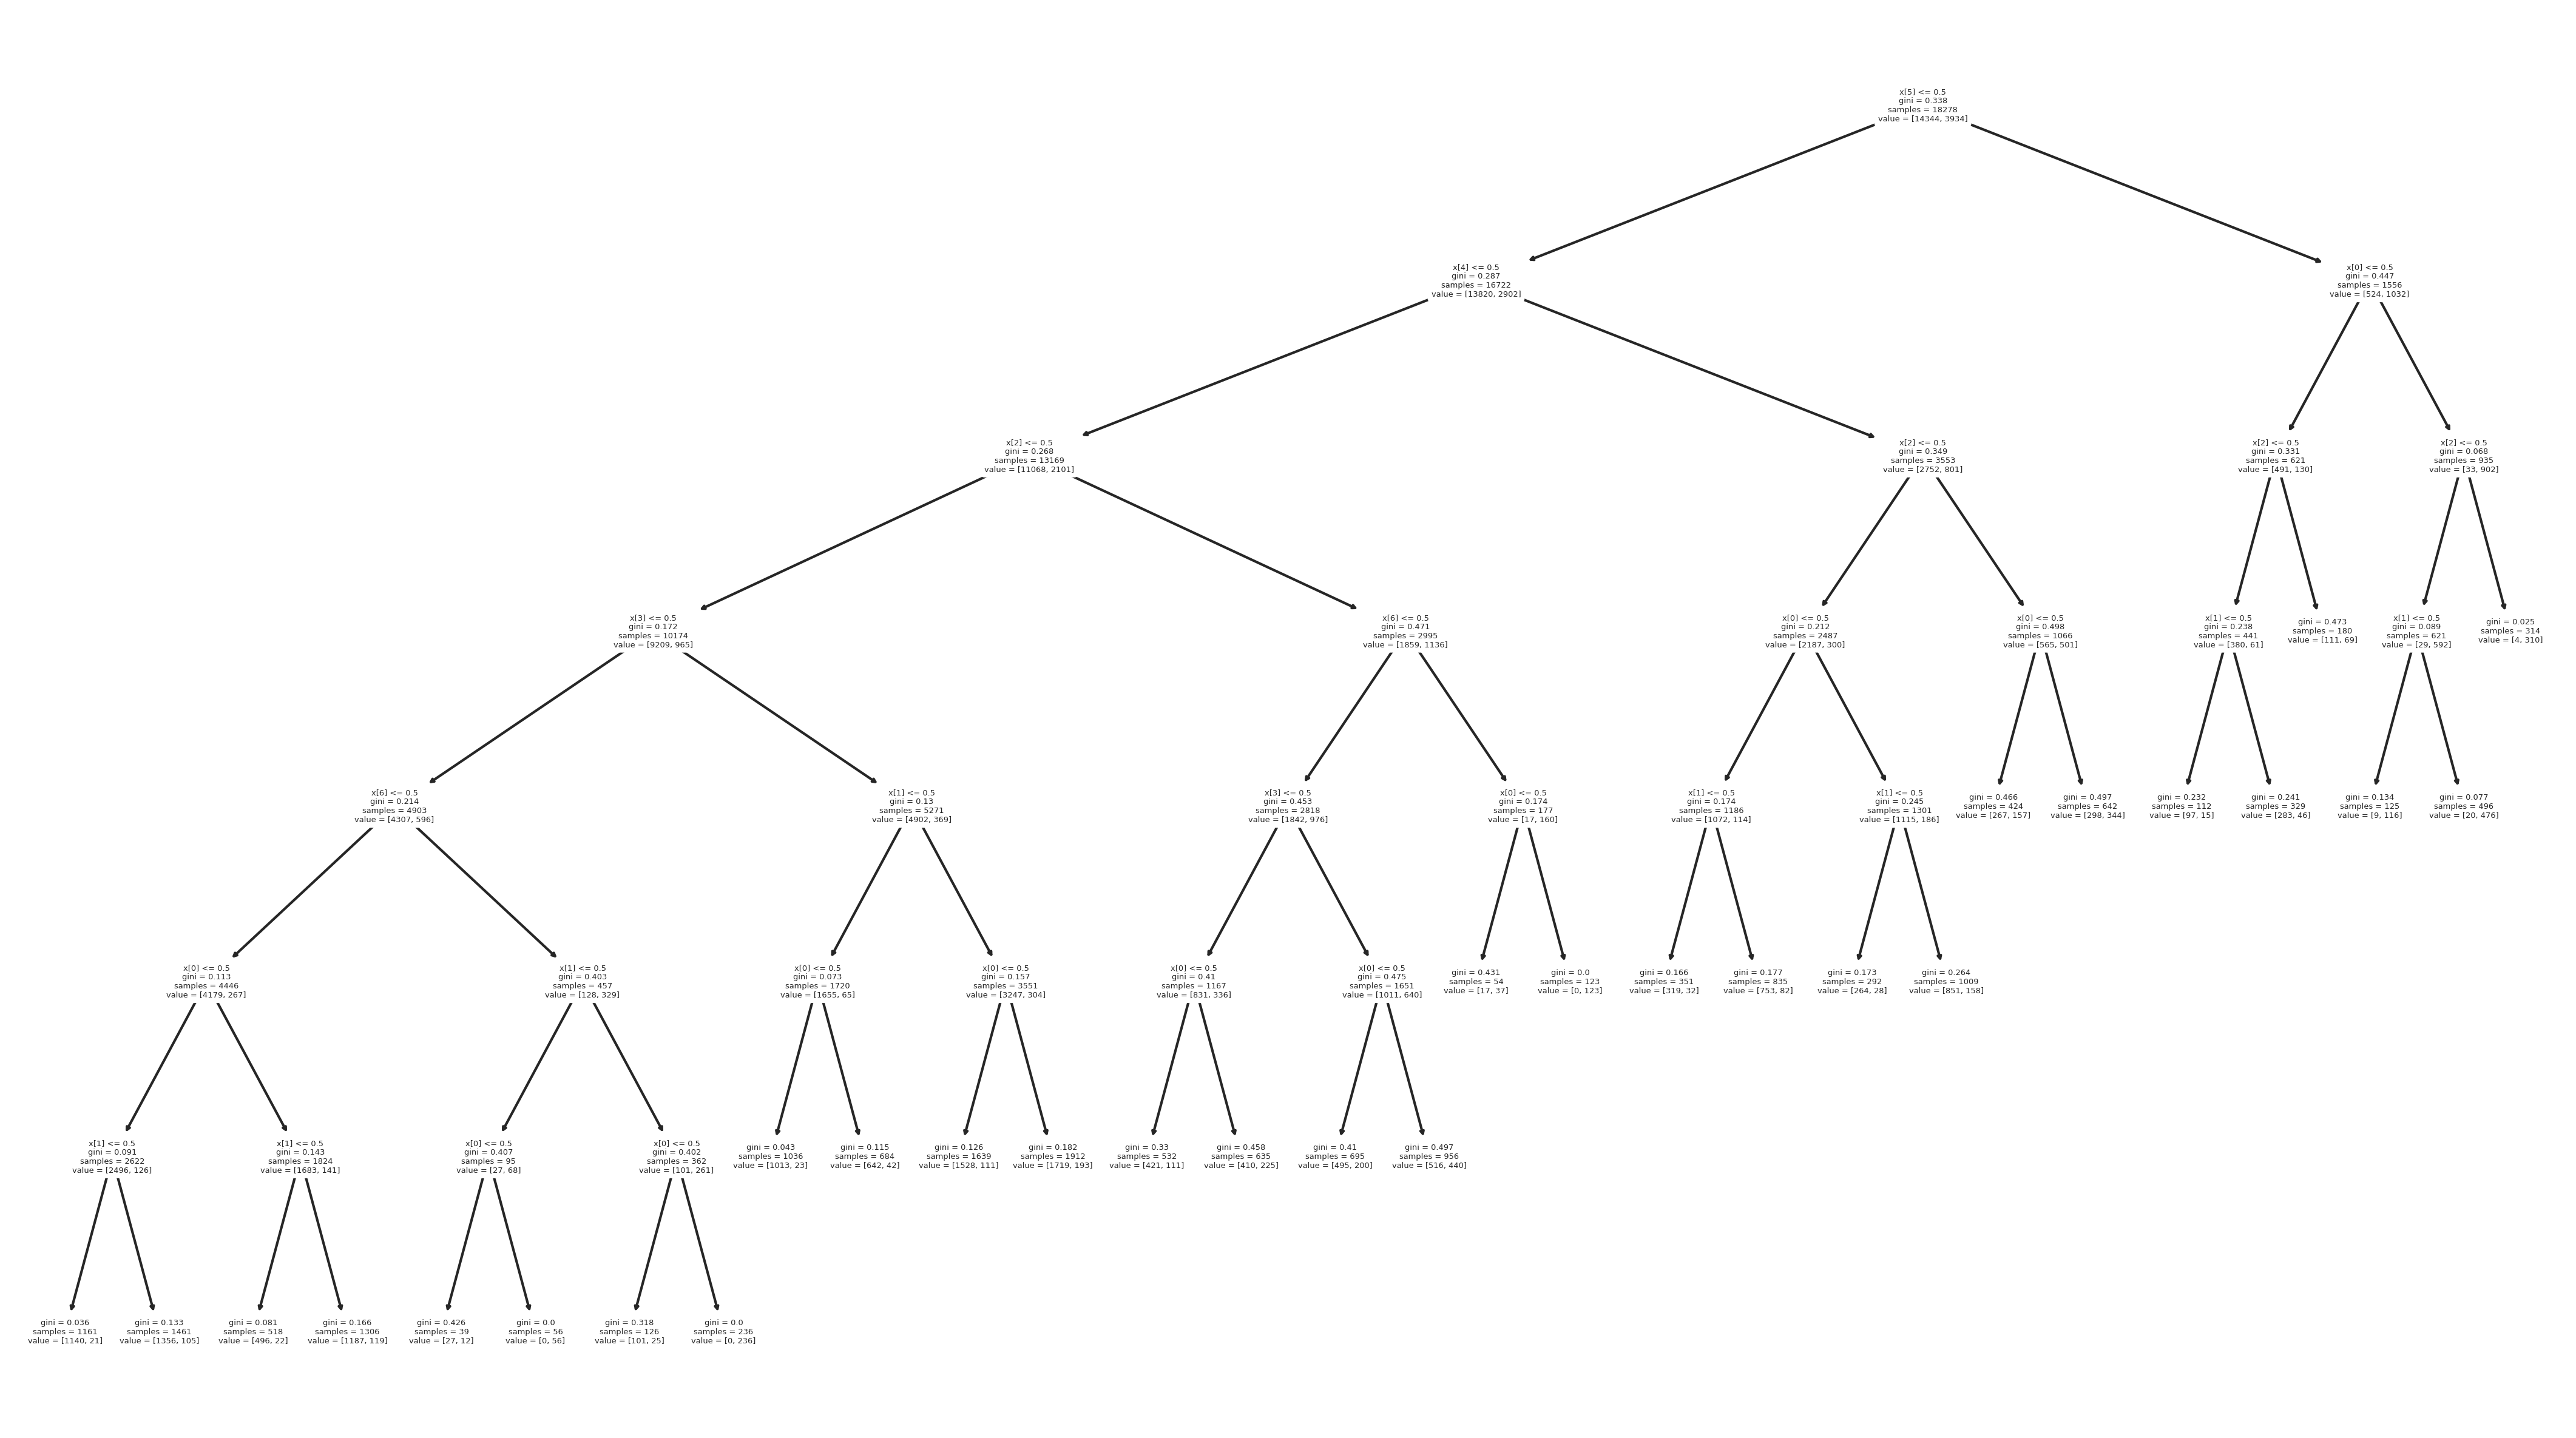

In [267]:
plt.figure(figsize=(18, 10))
tree.plot_tree(model_dt_train, rounded=True)
plt.show()

<ipython-input-25-119ebdb93eb2>:23: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p=np.mean(fit), alternative='greater').round(4)


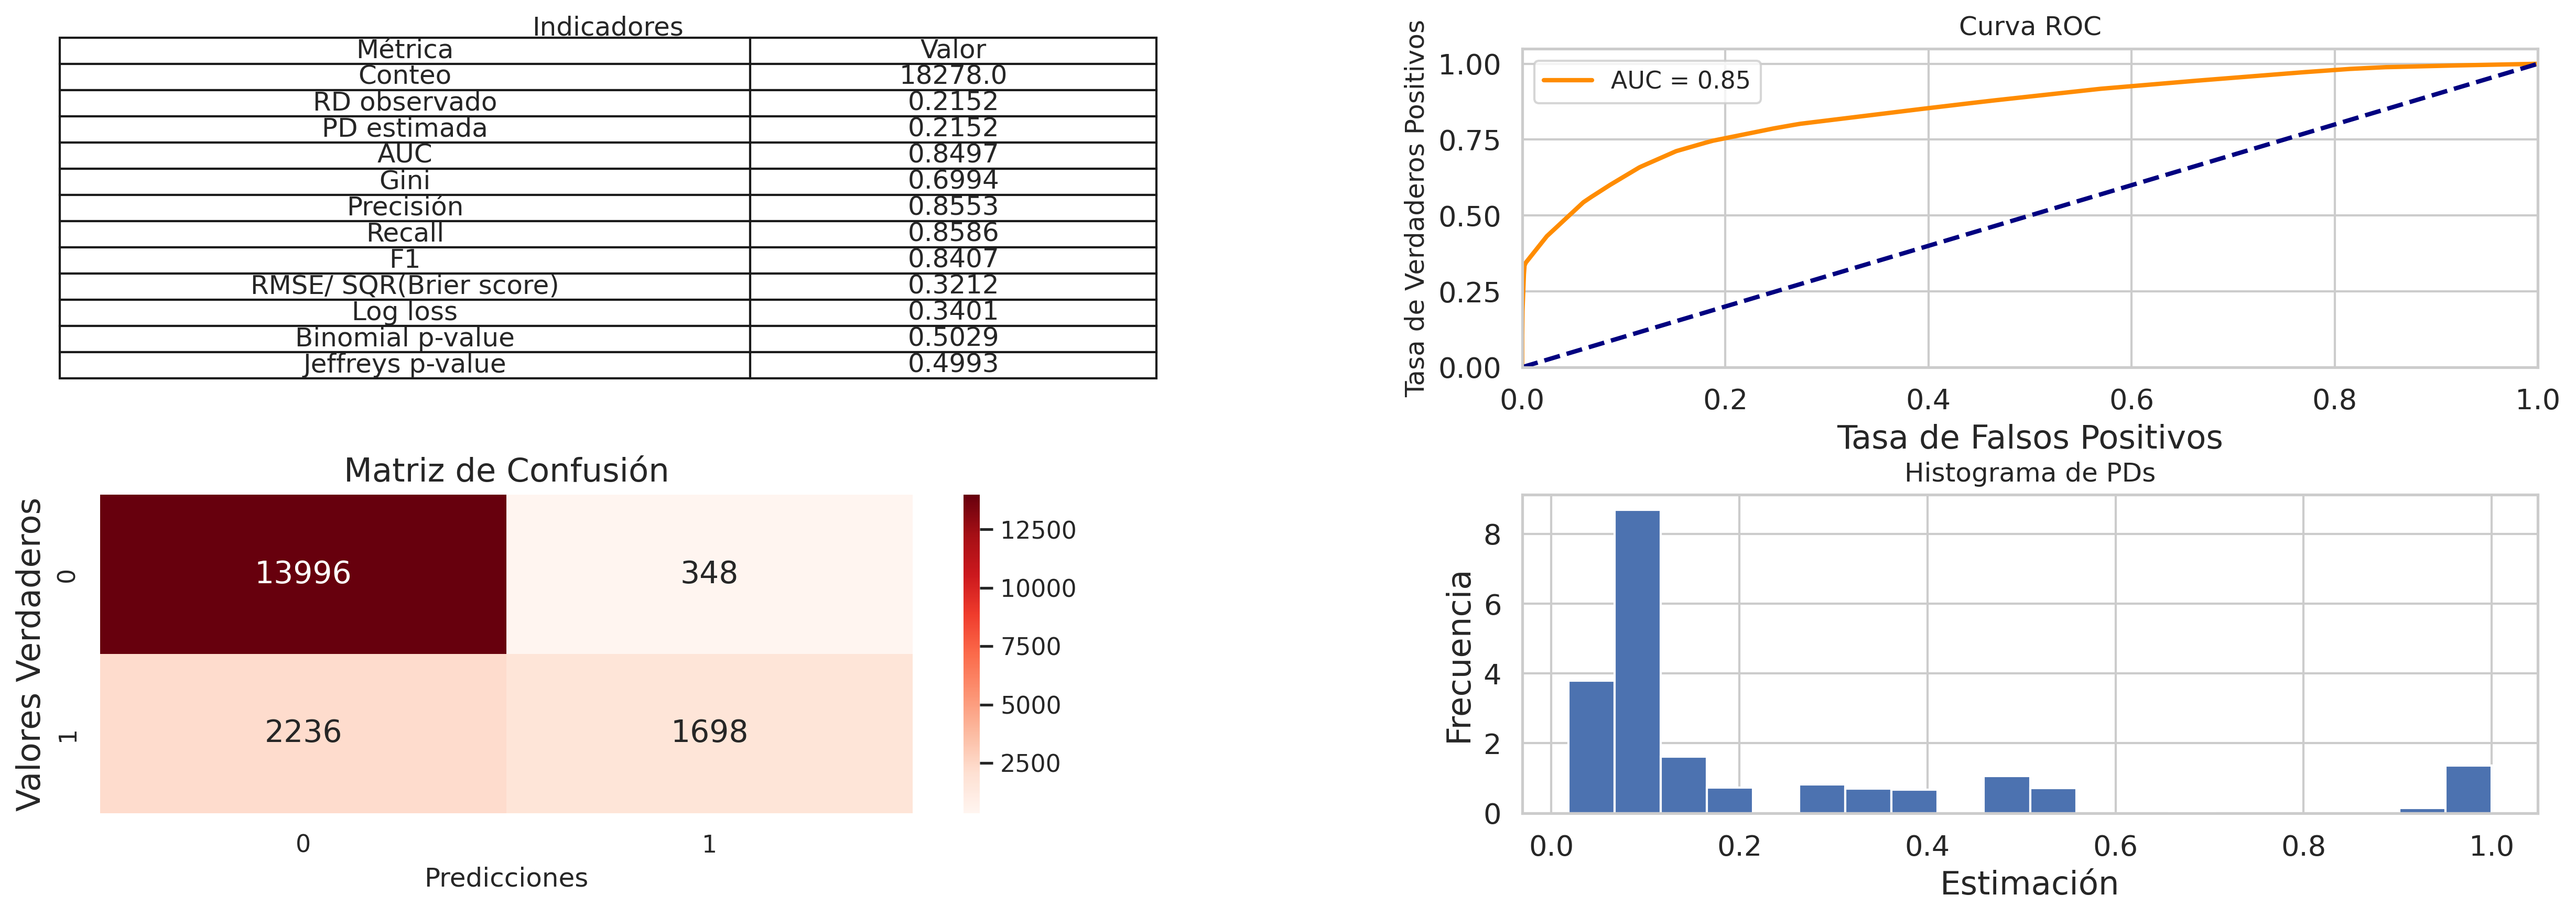

In [268]:
predictions_train = model_dt_train.predict_proba(X_train_ad)[:,1].T
predictions_train_1 = model_dt_train.predict(X_train_ad)

validation(predictions_train, predictions_train_1, y_train_ad, continuous=False)
AUC_dt = roc_auc_score(y_train_ad, predictions_train).round(4)
sqrt_brier_dt = np.sqrt(brier_score_loss(y_train_ad, predictions_train)).round(4)

Interpretación de métricas de bondad predictiva:

AUC: Tenemos un buen AUC, igual al obtenido anteriormente, pero con un número mucho menor de variables, con lo cual evitaremos overfitting y la validación no estará tan alejada de la data de entrenamiento.
INDICADORES: La PD estimada es idéntica a la RD, lo cual es mejor que en el logit. Un GINI excelente, pero tendremos que probarlo con la data de validación.Precisión y Recall altos también, lo cual es un buen indicador. El LOGLOSS es solo un poco mayor, pero no está tan alejado del valor del LOGIT, podríamos ser positivos si tomamos en cuenta que no estamos usando tantas variables (solo 9).

MATRIZ DE CONFUSIÓN:

La mayoría está correctamente clasificado con 13 996 verdaderos negativos.

348 falsos positivos, esto también es una pérdida para el banco porque se asumió que estos clientes caerían en default, cuando en realidad no.

2236 falsos negativos, son casos que equivalen a pérdidas para el banco porque no se midió el riesgo real.

1698 verdaeros positivos que son ahorros para el banco porque no se le prestó a clientes que efectivamente caerían en default a posteriori.

IMPORTANTE: El arbol se puede leer e interpretar, es lo suficientemente general para lograr ello